In [37]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import urllib.request as request

In [14]:
class Config:
    
    def __init__(self):
        self.ROOT_DATA_DIR = "hymenoptera_data"
        self.EPOCH = 10
        self.BATCH_SIZE = 32
        self.LEARNING_RATE = 0.01
        self.IMAGE_SIZE = (224, 224)
        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"this notebook is using device : {self.DEVICE}")
        self.SEED = 2022
        
    def create_dir(self, dir_path):
        os.makedirs(dir_path, exist_ok=True)
        print(f"{dir_path} directory is created.")
        
config = Config()

this notebook is using device : cpu


In [4]:
data_URL = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

In [6]:
config.create_dir(dir_path=config.ROOT_DATA_DIR)

hymenoptera_data directory is created.


In [7]:
data_zip_file = "data.zip"
data_file_path = os.path.join(config.ROOT_DATA_DIR, data_zip_file)
request.urlretrieve(data_URL, data_file_path)

('hymenoptera_data\\data.zip', <http.client.HTTPMessage at 0x26767e0b880>)

In [8]:
from zipfile import ZipFile

In [10]:
def unzip_file(source: str, dest: str) -> None:
    print("Extraction started")
    with ZipFile(source, "r") as zip_f:
        zip_f.extractall(dest)

In [11]:
unzip_file('hymenoptera_data\\data.zip', config.ROOT_DATA_DIR)

Extraction started


## Create Data Loaders

In [12]:
 from pathlib import Path

In [13]:
train_path = Path("hymenoptera_data/hymenoptera_data/train")
test_path = Path("hymenoptera_data/hymenoptera_data/val")

In [15]:
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

In [16]:
train_transforms = transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [17]:
train_data = datasets.ImageFolder(root=train_path, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_path, transform=test_transforms)

In [18]:
train_data.class_to_idx

{'ants': 0, 'bees': 1}

In [20]:
test_data.class_to_idx

{'ants': 0, 'bees': 1}

In [21]:
label_map = train_data.class_to_idx
label_map

{'ants': 0, 'bees': 1}

In [22]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=config.BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle=False, batch_size=config.BATCH_SIZE)

In [23]:
data = next(iter(train_loader))

In [24]:
len(data)

2

In [25]:
images, labels = data

In [26]:
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## Visualize one of the sample

In [27]:
img = images[0]

In [35]:
img.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


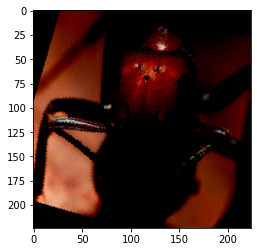

In [36]:
plt.imshow(img.permute(1,2,0))

## Download and use a pretrained model for transfer learning

In [38]:
model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [39]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Count the no of trainable parameters

In [41]:
from pyparsing.core import ParseAction

def count_params(model):
    model_params = {"Modules": list(), "Parameters": list()}
    total = {"trainable": 0, "non_trainable": 0}
    for name, parameters in model.named_parameters():
        # numel() returns the total no. of elements in the tensor
        param = parameters.numel()
        if not parameters.requires_grad:
            total["non_trainable"] += param
            continue
        model_params["Modules"].append(name)
        model_params["Parameters"].append(name)
        total["trainable"] += param

    df = pd.DataFrame(model_params)
    df = df.style.set_caption(f"Total parameters: {total}")
    return df

count_params(model) 

,Modules,Parameters
0,features.0.weight,features.0.weight
1,features.0.bias,features.0.bias
2,features.3.weight,features.3.weight
3,features.3.bias,features.3.bias
4,features.6.weight,features.6.weight
5,features.6.bias,features.6.bias
6,features.8.weight,features.8.weight
7,features.8.bias,features.8.bias
8,features.10.weight,features.10.weight
9,features.10.bias,features.10.bias


In [42]:
# Freeze all the layers

for parameters in model.parameters():
    parameters.requires_grad = False

In [44]:
count_params(model)

,Modules,Parameters


In [45]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [47]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=9216, out_features=100, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=100, out_features=2, bias=True)
)

In [48]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Drop

In [49]:
count_params(model)

,Modules,Parameters
0,classifier.0.weight,classifier.0.weight
1,classifier.0.bias,classifier.0.bias
2,classifier.3.weight,classifier.3.weight
3,classifier.3.bias,classifier.3.bias


## Training loop

In [50]:
model.to(config.DEVICE)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Drop

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [52]:
for epoch in range(config.EPOCH):
    with tqdm(train_loader) as tqdm_epoch:
        for images, labels in tqdm_epoch:
            tqdm_epoch.set_description(f"Epoch {epoch + 1} / {config.EPOCH}")
            images = images.to(config.DEVICE)
            labels = labels.to(config.DEVICE)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tqdm_epoch.set_postfix(loss=loss.item())
            

Epoch 10 / 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.14s/it, loss=0.0448]


## Save our Model

In [54]:
os.makedirs("model_dir", exist_ok=True)
model_file_path = os.path.join("model_dir", "CNN_ALEXNET_model.pth")
torch.save(model, model_file_path)

## Evaluate Model

In [55]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
    for batch, data in enumerate(test_loader):
        images = data[0].to(config.DEVICE)
        labels = data[1].to(config.DEVICE)
        
        y_pred = model(images)
        
        pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
        target = np.concatenate((target, labels.cpu().numpy()))

In [57]:
cm = confusion_matrix(target, pred)

In [58]:
cm

array([[60, 10],
       [11, 72]], dtype=int64)

## Prediction of our model